# Introduction

Eperiment with different blur detection methodologies and techniques.

Usefull resources:
- [PyImageSearch](https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv/)
- [Blur Detector Library](https://github.com/Utkarsh-Deshmukh/Spatially-Varying-Blur-Detection-python) and [Related Article](https://arxiv.org/pdf/1703.07478.pdf)
- [Blurry Image Detector](https://github.com/Utkarsh-Deshmukh/Blurry-Image-Detector)
- [Blur Kaggle Dataset](https://www.kaggle.com/datasets/kwentar/blur-dataset)
- [RealBlur Dataset](http://cg.postech.ac.kr/research/realblur/)
- [NVIDIA CUDA Installation Guide](https://docs.nvidia.com/cuda/archive/9.2/cuda-installation-guide-mac-os-x/index.html)

In [1]:
# Import Standard Libraries
import cv2
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from typing import List

import torch
from torch.utils.data import Dataset, DataLoader

# Change current directory with the upper one
os.chdir('./../')

# Import Package Libraries
from utils.feature_extraction import FeatureExtractor
from utils.data_loader import TestDataset

%matplotlib inline

In [2]:
# Set the device on which run PyTorch
# TODO: Install NVIDIA CUDA
torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Notebook's variables
blurry_images_directory = os.path.join('./data/blurry_sample_images/')
not_blurry_images_directory = os.path.join('./data/not_blurry_sample_images/')

In [4]:
# Retrieve sample blurry and not blurry images
blurry_images = [os.path.join(blurry_images_directory, file_name) for file_name in os.listdir(blurry_images_directory)]
not_blurry_images = [os.path.join(not_blurry_images_directory, file_name) for file_name in os.listdir(not_blurry_images_directory)]

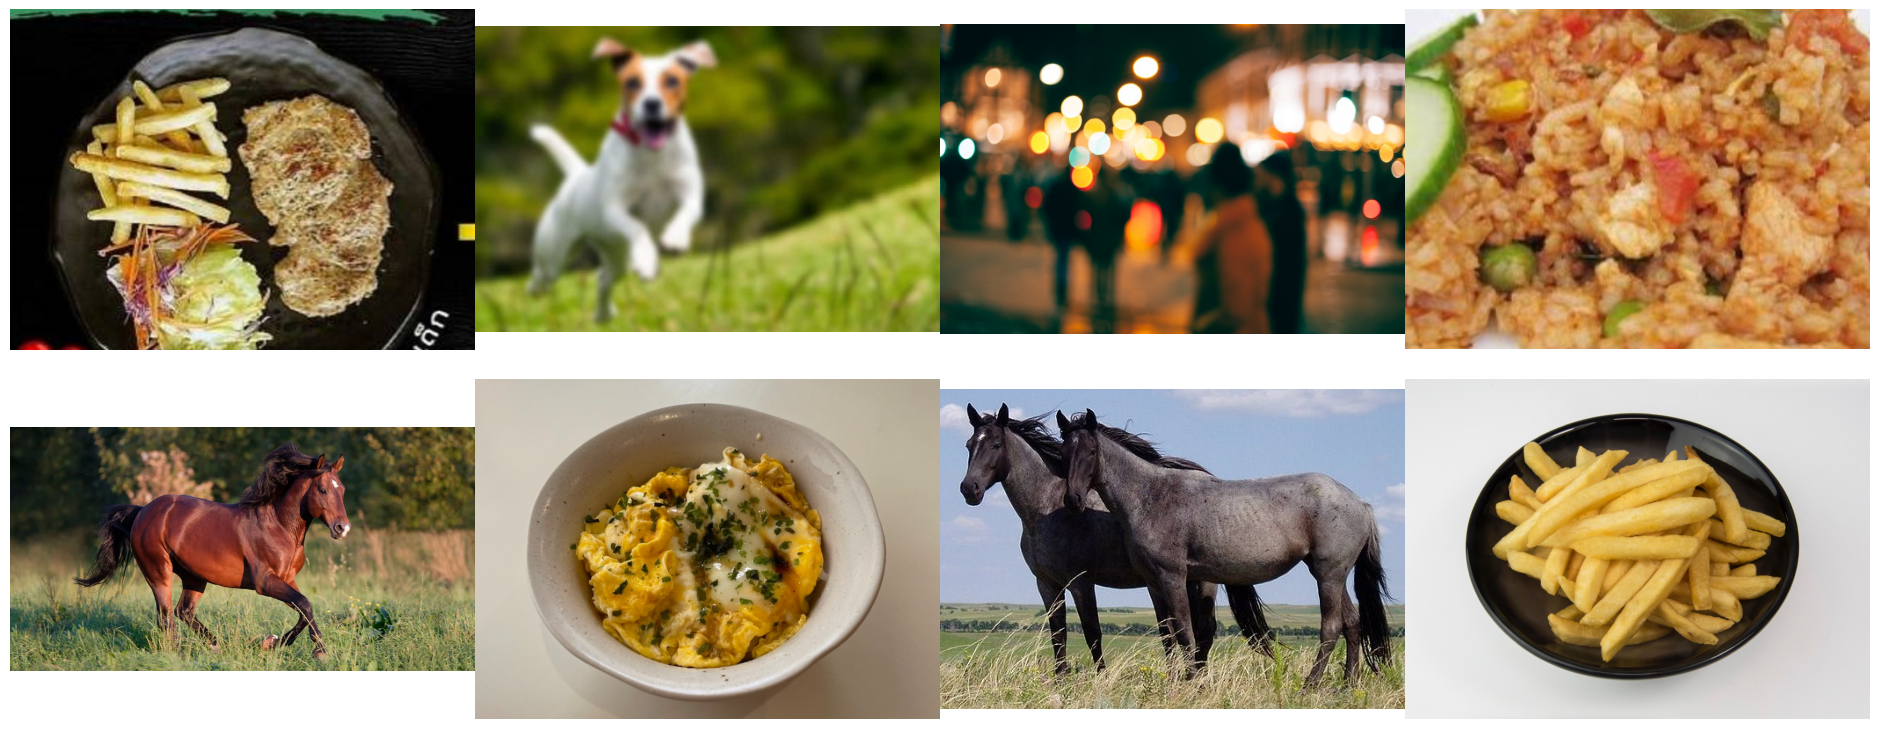

In [5]:
# Set number of rows and columns
nrows = 4
ncols = 4

# Set up matplotlib fig, and size it to fit 2x2 pics
fig = plt.gcf()
fig.set_size_inches(nrows*6, ncols*6)

# Plot sample images
for index, image_path in enumerate(blurry_images + not_blurry_images):

    # Retrieve image and show it
    subplot = plt.subplot(nrows, 
                          ncols, 
                          index + 1)
    subplot.axis('off')
    image = mpimg.imread(image_path)
    plt.imshow(image)
    
plt.subplots_adjust(wspace=0, hspace=-0.5)
plt.show()

# Utils Functions

## Compute Laplacian Variance

In [6]:
def compute_laplacian_variance(image: np.ndarray) -> float:
    """
    Compute the Variance of the Laplacian of the image
    
    Parameters:
        image: numpy.ndarray of the image
        
    Returns:
        laplacian_variance: float of Variance of the Laplacian of the image
    """
    
    # Compute the Variance of the Laplacian
    laplacian_variance = round(cv2.Laplacian(image, cv2.CV_64F).var(), 3)
    
    return laplacian_variance

## Read Image

In [7]:
def read_image_greyscale(image_path: str) -> np.ndarray:
    """
    Read an image from a String path and return the greyscale Numpy array of it
    
    Parameters:
        image_path: String image path
        
    Returns:
        image_greyscale: numpy.ndarray of the greyscale image
    """
    
    # Read the image through OpenCV
    image = cv2.imread(image_path)
    
    # Convert the image to greyscale
    image_greyscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    return image_greyscale

## Predict Blur Image

In [8]:
def predict_image_blur(model: torch.nn.Module, 
                       image: np.ndarray, 
                       threshold: float) -> bool:
    """
    Predict if the image is blurred or not
    
    Parameters:
        model: torch.nn.Module Neural Network Torch instance
        image: numpy.ndarray of image
        threshold: float of blur threshold
        
    Returns:
        prediction: bool if the image is blurried or not
    """
    
    # Initialise accumulator for predictions
    accumulator = []
    
    # Instantiate the Feature Extractor
    feature_extractor = FeatureExtractor()
    
    # Resize the image
    feature_extractor.resize_image(image, 
                                   np.shape(image)[0], 
                                   np.shape(image)[1])
    
    # Compute the image ROI using local entropy filter
    feature_extractor.compute_roi()
    
    # Extract the blur features using DCT transform coefficients
    extracted_features = feature_extractor.extract_feature()
    extracted_features = np.array(extracted_features)
    
    # If no features have been extracted, the image is blurred
    if len(extracted_features) == 0:
        return True
    
    # Create Dataset from 'extracted_features'
    dataset = TestDataset(extracted_features)
    
    # Load the image features as input data for the neural network
    data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    # Get model predictions over the extracted features
    for input_data in data_loader:
        
        # Get input data through the selected Torch device
        x = input_data.to(torch_device).float()

        # Get NN output
        output = model(x)
        
        # Get prediction
        _, predicted_label = torch.max(output, 1)
                
        # Append prediction
        accumulator.append(predicted_label.item())
                
    # Compute final prediction
    prediction = np.mean(accumulator) < threshold
    
    return prediction

## Get Prediction on a Dataset

In [9]:
def get_predictions_on_dataset(model: torch.nn.Module, 
                               images: List, 
                               blur_images: bool, 
                               threshold: float):
    
    """
    Compute accuracy over a set of images
    
    Parameters:
        model: torch.nn.Module Neural Network Torch instance
        images: List of numpy.ndarray image dataset
        blur_images: bool if the images are blurred or not
        threshold: float of blur threshold
        
    Returns:
        accuracy: float dataset accuracy
    """
    
    # Initialise number of correct predictions
    correct_predictions = 0
    
    # Fetch images
    for index, image_path in enumerate(images):
                
        # Read the image
        image = cv2.imread(image_path, 0)

        # Get prediction
        prediction = predict_image_blur(model, 
                                        image, 
                                        threshold)
        
        print('Image {} prediction: {}'.format(index, str(prediction)))
        print('\n')
        
        # Check the correctness of the prediction
        if prediction == blur_images:
            
            correct_predictions += 1
    
    # Compute accuracy
    accuracy = correct_predictions / len(images)
    
    return accuracy

# Variance of the Laplacian

The Laplacian operator is used to measure the 2nd derivative of an image. By taking the single greyscale channel of an image and convoluting it with a Laplacian kernel, it is possible to use the Variance as a blur indicator. The Laplacian highlights image's regions containing rapid intensity changes (like Sobel or Scharr operators). This is also the reason why it is quite adopted also for Edge Detection. 

The Laplacian carries two fundamental hypothesis within:

- If there is an high variance, then there is a wide spread of responses, both edge-like and non-edge like, which represent a normal in-focus image
- If there is a low variance, then there is a tiny spread of responses, indicating very little edge in the image and thus a blurry photo

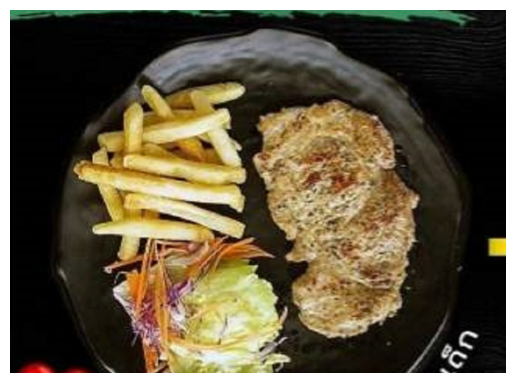

Blurried image 0 has a Variance of the Laplacian equals to: 71.943




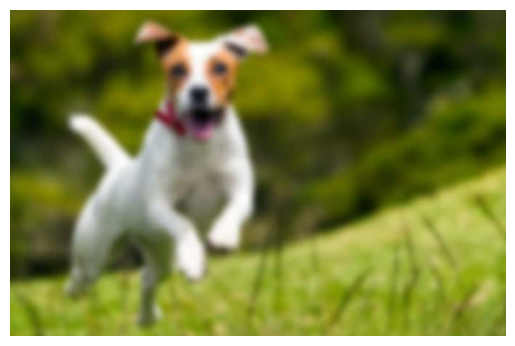

Blurried image 1 has a Variance of the Laplacian equals to: 7.57




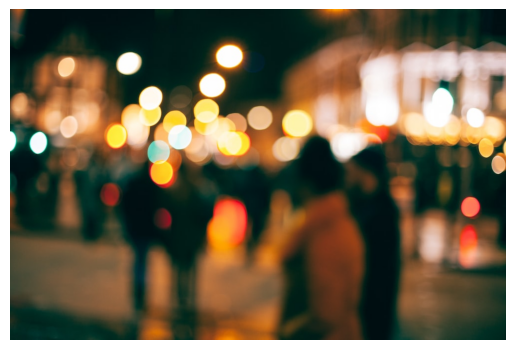

Blurried image 2 has a Variance of the Laplacian equals to: 27.989




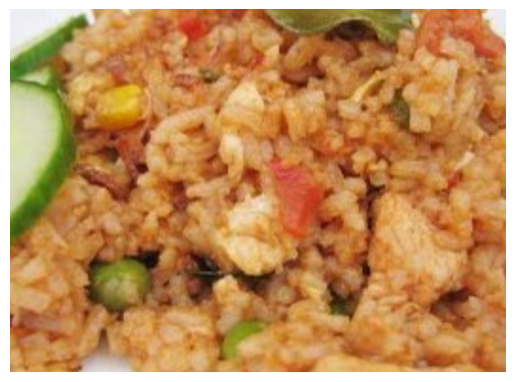

Blurried image 3 has a Variance of the Laplacian equals to: 14.944




In [10]:
# Compute the variance of the Laplacian of the blurried images
for index, image_path in enumerate(blurry_images):
    
    # Read the image
    image_greyscale = read_image_greyscale(image_path)
    
    # Show Image
    image = mpimg.imread(image_path)
    plt.axis('off')
    plt.imshow(image)
    plt.show()
    
    print('Blurried image {} has a Variance of the Laplacian equals to: {}'.format(index, compute_laplacian_variance(image_greyscale)))
    print('\n')

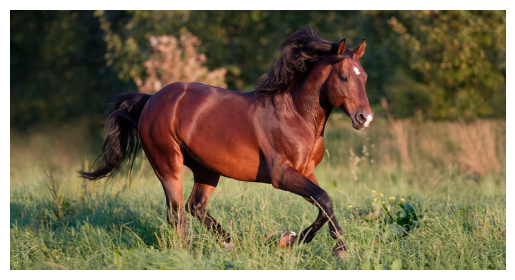

NOT Blurried image 0 has a Variance of the Laplacian equals to: 585.759




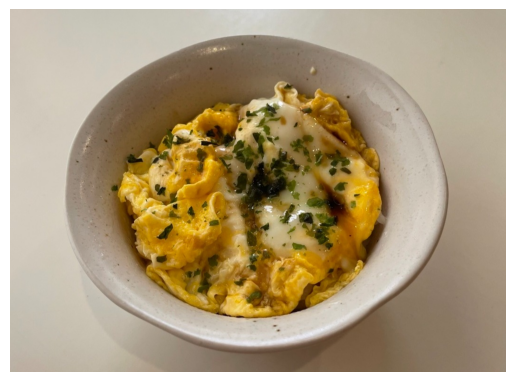

NOT Blurried image 1 has a Variance of the Laplacian equals to: 101.11




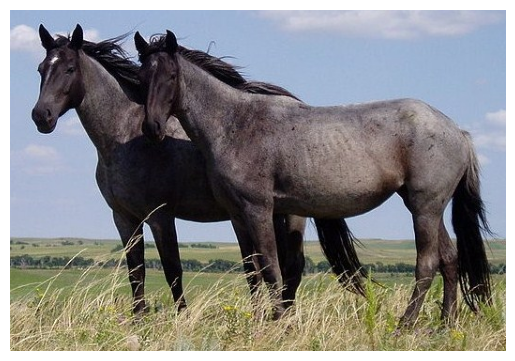

NOT Blurried image 2 has a Variance of the Laplacian equals to: 4432.184




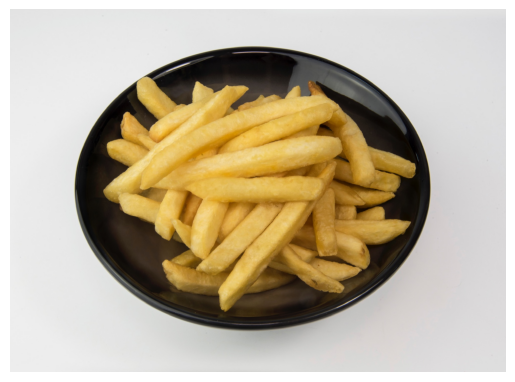

NOT Blurried image 3 has a Variance of the Laplacian equals to: 22.099




In [11]:
# Compute the variance of the Laplacian of the NOT blurried images
for index, image_path in enumerate(not_blurry_images):
    
    # Read the image
    image_greyscale = read_image_greyscale(image_path)
    
    # Show Image
    image = mpimg.imread(image_path)
    plt.axis('off')
    plt.imshow(image)
    plt.show()
    
    print('NOT Blurried image {} has a Variance of the Laplacian equals to: {}'.format(index, compute_laplacian_variance(image_greyscale)))
    print('\n')

The distinction is not relevant unfortunately. It would be hard to come up with a good splitter, especially because some dishes have a low variance only because there are not many "ingredients shown".

# Neural Network with Feature Extraction over ROI

Identify ROI (Regions of Interest) in the image through local entropy filtering for further Feature Extraction through DCT and selecting High-Frequency Coefficients. Use such coefficients to train a Fully Connected Neural Netowkr for Blur Classification.

Based on the work of the following [GitHub Repository](https://github.com/Utkarsh-Deshmukh/Blurry-Image-Detector).

## Restore Pre-Trained Model

In [12]:
# Import pre-trained model (NOTE: It requires the NN definition in utils.MLP)
torch_model = torch.load('./models/trained_model-Kaggle_dataset')

In [13]:
# Restore model state
torch_model_state = torch_model['model_state']

## Compute Accuracy

In [14]:
get_predictions_on_dataset(torch_model_state, blurry_images, True, 0.5)

compute_roi
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(323, 442)
Image 0 prediction: True


compute_roi
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
(223, 339)
Image 1 prediction: True


compute_roi
[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(333, 500)
Image 2 prediction: True


compute_roi
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(288, 394)
Image 3 prediction: True




1.0

In [15]:
get_predictions_on_dataset(torch_model_state, not_blurry_images, False, 0.5)

compute_roi
[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(315, 600)
Image 0 prediction: False


compute_roi
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(384, 526)
Image 1 prediction: False


compute_roi
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(182, 264)
Image 2 prediction: False


compute_roi
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(729, 997)
Image 3 prediction: True




0.75